In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from functions import *

In [29]:
scaled_data, scaler, target_column_index, df = get_df(data_size=10000)


                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1984-09-27  0.114955  0.115513  0.114955  0.114955   0.088721  105929600
1984-09-28  0.114955  0.114955  0.109933  0.112165   0.086568  233408000
1984-10-01  0.111607  0.111607  0.109375  0.109375   0.084415   97776000
1984-10-02  0.110491  0.114397  0.110491  0.110491   0.085276  118249600
1984-10-03  0.112165  0.113839  0.112165  0.112165   0.086568  120422400


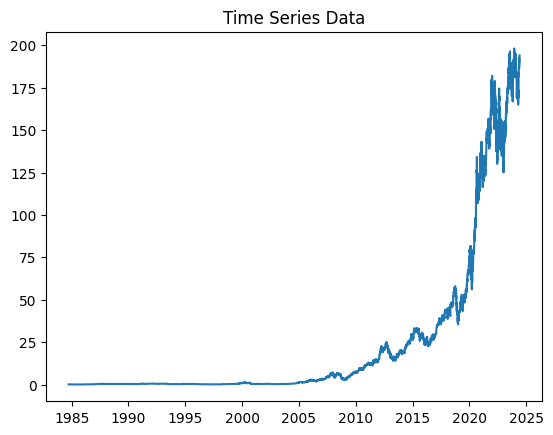

In [30]:
print(df.head())
plt.plot(df['Close'])
plt.title('Time Series Data')
plt.show()

In [31]:
# X, Y, feature_number, time_step = create_dataset(data=scaled_data)
X = df.drop(columns=['Close'])
Y = df['Close']

In [32]:
print(X.shape, Y.shape)

(10000, 5) (10000,)


In [33]:
# Train an XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [34]:
model.fit(X, Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [36]:
# Extract feature importances
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Print feature importances
print(importance_df)

     feature  importance
3  Adj Close    0.518072
1       High    0.287242
2        Low    0.122023
0       Open    0.072631
4     Volume    0.000031


In [37]:
# Select top features
selected_features = importance_df[importance_df['importance'] > 0]['feature'].tolist()

print("Selected features:", selected_features)

Selected features: ['Adj Close', 'High', 'Low', 'Open', 'Volume']


In [38]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [39]:
# Use selected features for further modeling
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train a new model with selected features
model_selected = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model_selected.fit(X_train_selected, Y_train)

# Predict and evaluate
Y_pred = model_selected.predict(X_test_selected)
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error with selected features: {mse}')

Mean Squared Error with selected features: 6160.901857147104
